# Sentiment Analysis with LSTMs

### Dependencies

In [1]:
import os
import re
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import word_tokenize

%matplotlib inline

### Files and directories

In [2]:
# directories
saved_dir = 'saved/'
model_dir = 'models/'
dataset_dir = 'datasets/'
tensorboard_dir = 'tensorboard/'
chkpt_dir = os.path.join(tensorboard_dir, 'chkpt/')

# dataset
pos_dir = os.path.join(dataset_dir, 'positiveReviews')
neg_dir = os.path.join(dataset_dir, 'negativeReviews')

# saved files
word_list_file = os.path.join(saved_dir, 'wordsList.npy')
word_vector_file = os.path.join(saved_dir, 'wordVectors.npy')
ids_matrix_file = os.path.join(saved_dir, 'idsMatrix.npy')

# log files
log_path = os.path.join(tensorboard_dir, '{:%d-%b-%Y  %H-%M-%S-%p}'.format(dt.datetime.now()))
pre_trained_path = os.path.join(chkpt_dir, 'model.ckpt')

### word lists and embedding matrix (word vectors)

In [3]:
# word lists
word_list = np.load(word_list_file).tolist()
word_list = [word.decode('UTF-8') for word in word_list]
print(word_list[:50])

# word vectors/embedding matrix
word_vectors = np.load(word_vector_file)
print('\nWord vector: {:,}x{:,}'.format(*word_vectors.shape))

['0', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after']

Word vector: (400000, 50)


### Converting words to vectors

In [4]:
word = 'billion'
word_idx = word_list.index(word.lower())
print(word_vectors[word_idx])

# Free memory
del word
del word_idx

[ 0.21994001 -0.014414   -0.24502    -0.31895    -0.32942    -0.48162001
 -1.58179998  0.27079001 -1.36129999  0.05855    -0.10478    -0.44319001
 -0.40213001  0.05586     0.81841999  0.30684999 -1.00090003 -0.83020002
 -1.22590005  0.54736     0.60422999  0.33344999  0.02349    -0.58297998
  0.068311   -1.49609995  0.12819    -0.18686    -0.17151     0.90003002
  3.19050002 -0.59917003 -0.097557   -0.021908    0.54973    -0.14088
  0.18978     0.34742999 -0.061865   -0.067381   -0.52579999  0.55704999
 -0.56489998 -0.42131001  0.24299     0.1408     -0.074287   -0.41503
 -0.17553    -0.62826002]


### Converting a sentence into `ids`

![Embedding lookup](Images/SentimentAnalysis5.png)

In [5]:
pos_files = [os.path.join(pos_dir, f) 
             for f in os.listdir(pos_dir) 
             if f[0] != '.' and os.path.isfile(os.path.join(pos_dir, f))]
neg_files = [os.path.join(neg_dir, f) 
             for f in os.listdir(neg_dir) 
             if f[0] != '.' and os.path.isfile(os.path.join(neg_dir, f))]
# Combination
files = pos_files + neg_files

In [6]:
print('{}\t{:,}\n'.format(pos_files[:2], len(pos_files)))
print('{}\t{:,}\n'.format(neg_files[:2], len(neg_files)))
print('Total: {:,}'.format(len(files)))

['datasets/positiveReviews/0_9.txt', 'datasets/positiveReviews/10000_8.txt'] 
12,500

['datasets/negativeReviews/0_3.txt', 'datasets/negativeReviews/10000_4.txt'] 
12,500



### Average and total number of words in dataset

In [7]:
def get_num_words(data_files):
    num_words = []
    for df in data_files:
        text = open(df, 'r', encoding='utf-8').read()
        word_count = len(text.split())
        num_words.append(word_count)
        sys.stdout.write('\r{:,} of {:,} files to go...'.format(i+1, len(data_files))
    return num_words

In [8]:
word_count = get_num_words(files)

Done with datasets positiveReviews
Done with datasets negativeReviews


In [9]:
n_files = len(word_count)
total = sum(word_count)
avg = sum(word_count) / len(word_count)
max_seq_len = 250 # int(avg)
word_vector_dim = 300

print('Total number of files: {:,}'.format(n_files))
print('Sum of words: {:,}'.format(total))
print('Average words: {:.02f}'.format(avg))

Total number of files: 25,000
Sum of words: 5,844,680
Average words: 233.79


### Plotting distributions

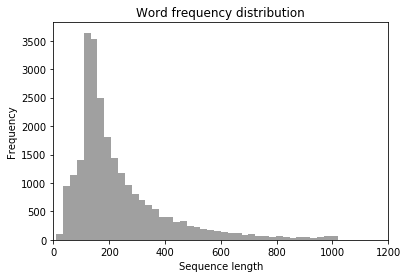

In [10]:
plt.hist(word_count, 100, color='#a0a0a0')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.xlim(0, 1200)
plt.title('Word frequency distribution')
plt.show()

In [ ]:
# Free up memory

del word_count
del n_files
del total
del avg
del pos_files
del neg_files

### Looking into the reviews

In [11]:
# Before cleaning
print(open(files[0], 'r', encoding='utf-8').read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


### Cleaning up the sentences

In [12]:
special_chars = re.compile('[^A-Za-z0-9 ]+')

def clean(string):
    string = string.lower().replace('<br />', ' ')
    return re.sub(special_chars, '', string)

In [13]:
# After cleaning
print(clean(open(files[0], 'r', encoding='utf-8').read()))

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt


In [14]:
def get_ids(data_files, word_list, max_seq_len=250, **kwargs):
    # retrieve keyword arugments
    save_file = kwargs['save_file'] if 'save_file' in kwargs else 'saved/ids.npy'
    force = kwargs['force'] if 'force' in kwargs else False
    logging = kwargs['logging'] if 'logging' in kwargs else False
    
    # load saved file if it exist and we're not forcing an override
    should_load_saved = os.path.isfile(save_file) and not force
    if should_load_saved:
        return np.load(save_file)
    
    # The file doesn't exist or we are forcing an override
    num_files = len(data_files)
    ids = np.zeros(shape=[num_files, max_seq_len], dtype=np.int32)
    # converting data files to ids...
    if logging:
        print('Converting to ids: {}'.format(ids.shape))

    for i, df in enumerate(data_files):
        words = clean(open(df, 'r', encoding='utf-8').read())
        words = words.split()
        for j, word in enumerate(words):
            try:
                ids[i, j] = word_list.index(word)
            except:
                # vector for unknown words
                ids[i, j] = word_list.index('unk')
            finally:
                if j >= max_seq_len:
                    break
            if logging:
                sys.stdout.write('\rCreating ids... {:,} of {:,}'.format(i+1, num_files))
    # done creating...
    if logging:
        print('Done creating ids for {}'.format(' '.join(data_files[0].split('/')[:-1])))
    
    np.save(save_file, ids)
    return ids

In [15]:
ids = get_ids(files, word_list, max_seq_len=max_seq_len, save_file=ids_matrix_file, logging=True)
print(ids.shape)

(25000, 250)


### Hyperparameters

In [16]:
batch_size = 24
num_classes = 2
lstm_units = 64
dropout = 0.80  # 20% dropout
learning_rate = 1e-3
iterations = 50000
save_interval = int(iterations / 100)
print('Iterations = {:,}\t Save interval = {:,}'.format(iterations, save_interval))

Iterations = 50,000	 Save interval = 500


### Training and testing batch helper functions

In [17]:
def getTrainBatch():
    labels = []
    arr = np.zeros(shape=[batch_size, max_seq_len])
    for i in range(batch_size):
        if (i % 2 == 0):
            num = np.random.randint(1, 11499)
            labels.append([1, 0])
        else:
            num = np.random.randint(13499, 24999)
            labels.append([0, 1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batch_size, max_seq_len])
    for i in range(batch_size):
        num = np.random.randint(11499, 13499)
        if (num <= 12499):
            labels.append([1, 0])
        else:
            labels.append([0, 1])
        arr[i] = ids[num-1:num]
    return arr, labels

## Building the Model

#### Resetting `tensorflow`'s default `Graph`

In [18]:
tf.reset_default_graph()

### Defining the placeholder variables

As with most Tensorflow graphs, we’ll now need to specify two placeholders, one for the inputs into the network, and one for the labels. The most important part about defining these placeholders is understanding each of their dimensionalities.

The labels placeholder represents a set of values, each either [1, 0] or [0, 1], depending on whether each training example is positive or negative i.e. **`batch_size x num_classes`**. Each row in the integerized input placeholder represents the integerized representation of each training example that we include in our batch i.e **`batch_size x max_seq_len`**

![Placeholder dimensions](Images/SentimentAnalysis12.png)

In [19]:
X = tf.placeholder(tf.int32, shape=[batch_size, max_seq_len])
y = tf.placeholder(tf.float32, shape=[batch_size, num_classes])
y_true = tf.argmax(y, axis=1)

Once we have our input data placeholder, we’re going to call the **`tf.nn.embedding_lookup()`** function in order to get our word vectors. The call to that function will return a 3-D Tensor of dimensionality **_batch size by max sequence length by word vector dimensions._** In order to visualize this 3-D tensor, you can simply think of each data point in the integerized input tensor as the corresponding D dimensional vector that it refers to.
![Lookup](Images/SentimentAnalysis13.png)

In [20]:
embedding = tf.nn.embedding_lookup(word_vectors, X)
print(embedding)

Tensor("embedding_lookup:0", shape=(24, 250, 50), dtype=float32)


Now that we have the `embedding` in the format that we want, let’s look at how we can feed this input into an **LSTM network**. We’re going to call the **`tf.contrib.rnn.BasicLSTMCell`** function. This function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer by calling the **`tf.contrib.rnn.DropoutWrapper`** function to help prevent the network from overfitting.

Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input `embedding` into a function called **`tf.nn.dynamic_rnn`**. This function is in charge of unrolling the whole network and creating a pathway for the `embedding` to flow through the RNN graph.

In [21]:
help(tf.nn.dynamic_rnn)

Help on function dynamic_rnn in module tensorflow.python.ops.rnn:

dynamic_rnn(cell, inputs, sequence_length=None, initial_state=None, dtype=None, parallel_iterations=None, swap_memory=False, time_major=False, scope=None)
    Creates a recurrent neural network specified by RNNCell `cell`.
    
    Performs fully dynamic unrolling of `inputs`.
    
    `Inputs` may be a single `Tensor` where the maximum time is either the first
    or second dimension (see the parameter
    `time_major`).  Alternatively, it may be a (possibly nested) tuple of
    Tensors, each of them having matching batch and time dimensions.
    The corresponding output is either a single `Tensor` having the same number
    of time steps and batch size, or a (possibly nested) tuple of such tensors,
    matching the nested structure of `cell.output_size`.
    
    The parameter `sequence_length` is optional and is used to copy-through state
    and zero-out outputs when past a batch element's sequence length. So it's m

In [22]:
lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstm_units)
lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=dropout)
# create RNN specified by the `lstm_cell` (performs fully dynamic unrolling of `embedding`)
outputs, state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=embedding, dtype=tf.float32)
# outputs is the RNN output while state is the final state

As a side note, another more advanced network architecture choice is to stack multiple LSTM cells on top of each other. This is where the final hidden `state` vector of the first LSTM feeds into the second. Stacking these cells is a great way to help the model retain more long term dependence information, but also introduces more parameters into the model, thus possibly increasing the training time, the need for additional training examples, and the chance of overfitting. For more information on how you can add stacked LSTMs to your model, check out Tensorflow's excellent [documentation](https://www.tensorflow.org/tutorials/recurrent#stacking_multiple_lstms).

The first `output` of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [23]:
W = tf.Variable(tf.truncated_normal(shape=[lstm_units, num_classes], mean=0, stddev=1.))
b = tf.Variable(tf.zeros(shape=[num_classes]))
outputs = tf.transpose(outputs, [1, 0, 2])
last = tf.gather(outputs, int(outputs.get_shape()[0])-1)
y_pred = tf.matmul(last, W) + b

### Evaluate Model's accuracy

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then s
eeing whether it matches with the training labels.

In [24]:
y_pred_true = tf.argmax(y_pred, axis=1)
correct = tf.equal(y_pred_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Loss function and optimization

In [25]:
xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y, name='cross_entropy')
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

## Defining the `tf.Session`

In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## Tensorboard Visualization `tf.summary`

In [27]:
saver = tf.train.Saver()

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram('Weights', W)
tf.summary.histogram('Biases', b)
merged = tf.summary.merge_all()

writer = tf.summary.FileWriter(logdir=log_path, graph=sess.graph)

## Training

In [28]:
for i in tqdm(range(iterations), desc='Training'):
   # Next Batch of reviews
    X_batch, y_batch = getTrainBatch();
    sess.run(train_step, {X: X_batch, y: y_batch})

    # Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {X: X_batch, y: y_batch})
        writer.add_summary(summary, i)

    # Save the network every 10,000 training iterations
    if (i % save_interval == 0 and i == iterations-1):
        save_path = saver.save(sess, save_path=pre_trained_path, global_step=i)
        tqdm.write('Saved to {}'.format(save_path))
writer.close()

Training:  60%|██████    | 30001/50000 [3:39:38<2:27:14,  2.26it/s]   

KeyboardInterrupt: 

### Loading Pretrained model

In [ ]:
# saver.restore(sess, tf.train.latest_checkpoint(chkpt_dir))

### Test data `accuracy`

In [29]:
iterations = 10
for i in range(iterations):
    X_batch, y_batch = getTestBatch();
    print("Accuracy for this batch: {:.2%}".format(sess.run(accuracy, {X: X_batch, y: y_batch})))

Accuracy for this batch: 100.00%
Accuracy for this batch: 83.33%
Accuracy for this batch: 87.50%
Accuracy for this batch: 66.67%
Accuracy for this batch: 79.17%
Accuracy for this batch: 95.83%
Accuracy for this batch: 75.00%
Accuracy for this batch: 91.67%
Accuracy for this batch: 95.83%
Accuracy for this batch: 83.33%


### Prediction

In [30]:
def get_embedding_matrix(sentence):
    matrix = np.zeros(shape=[batch_size, max_seq_len], dtype=np.int32)
    clean_sent = clean(sentence)
    split = clean_sent.split()
    for i, word in enumerate(split):
        try:
            matrix[0, i] = word_list.index(word)
        except ValueError:
            matrix[0, i] = word_list.index('unk')  # Vector for unkown words
    return matrix

In [31]:
def test(text):

    text_embedding = get_embedding_matrix(text)
    sentiment = sess.run(y_pred, feed_dict={X: text_embedding})[0]
    return np.argmax(sentiment)

In [37]:
text = input('Enter a movie review: ')
sentiment = test(text)

pred = 'Positive sentiment' if sentiment else 'Negative sentiment'
print(pred)

Enter a movie review: I'm not a fan. It's didn't interest me
Negative sentiment


In [40]:
text = input('Enter a movie review: ')
sentiment = test(text)

pred = 'Positive sentiment' if sentiment else 'Negative sentiment'
print(pred)

Enter a movie review: I can't wait to watch it again!
Positive sentiment
